## Run this top cell to download and extract the flowers data

In [29]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed for random number generation so my results are reproducible
np.random.seed(42069)

In [30]:
# Import the oxford_flowers102 dataset
dataset, datasetInfo = tfds.load('oxford_flowers102', with_info=True, split='train')

# Print the dataset info
print(datasetInfo)


tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
    in the United Kingdom. Each class consists of between 40 and 258 images. The images have
    large scale, pose and light variations. In addition, there are categories that have large
    variations within the category and several very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set.
    The training set and validation set each consist of 10 images per class (totalling 1020 images each).
    The test set consists of the remaining 6149 images (minimum 20 per class).
    
    Note: The dataset by default comes with a test size larger than the train
    size. For more info see this [issue](https://github.com/tensorflow/datasets/issues/3022).
    """,
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    data

The image sizes vary a lot, so we'll resize them to 224x224 pixels

In [31]:
# Print the first 5 images in the dataset
for i, example in enumerate(dataset.take(5)):
		print(example['image'].shape)
		print(example['label'])

(500, 667, 3)
tf.Tensor(72, shape=(), dtype=int64)
(500, 666, 3)
tf.Tensor(84, shape=(), dtype=int64)
(670, 500, 3)
tf.Tensor(70, shape=(), dtype=int64)
(500, 505, 3)
tf.Tensor(51, shape=(), dtype=int64)
(500, 672, 3)
tf.Tensor(48, shape=(), dtype=int64)


In [32]:
# Resize the images to 224x224
def resizeImage(image):
	image['image'] = tf.image.resize(image['image'], [224, 224])
	image['image'] = tf.cast(image['image'], dtype = tf.float32)
	return image

# Resize the images
dataset = dataset.map(resizeImage)


In [37]:
train_data = dataset.shuffle(buffer_size=1000).batch(batch_size=32)#.prefetch(buffer_size=tf.data.AUTOTUNE)

In [38]:
for i, example in enumerate(train_data.take(5)):
		print(example['image'].shape)
		print(example['label'])

(32, 224, 224, 3)
tf.Tensor(
[12 73 65 66 89 65 58 93 80 73 93 97  5 24 29 78 16 60 10 16 76 96 70 34
 80 47 25 82 22 39 74 79], shape=(32,), dtype=int64)
(32, 224, 224, 3)
tf.Tensor(
[ 84  37  81   1  64  18  68  71  48  46  75  15  22  72  93  10  70 101
  22  17  46  97 100  88  68  78  65   6  62  24  93  94], shape=(32,), dtype=int64)
(32, 224, 224, 3)
tf.Tensor(
[ 49  62  14  26  89 101  20  86  90  36  43  16  11  71  19  32  81  20
  59  48  54  12  38   3  33  79  89   6  63  19   1  60], shape=(32,), dtype=int64)
(32, 224, 224, 3)
tf.Tensor(
[95 52 10 64 33 36 86 69 46 94  4 81 82 93 58 83 19 76 36 16 91 87 33  5
 13 62 87 99 31 58 88 37], shape=(32,), dtype=int64)
(32, 224, 224, 3)
tf.Tensor(
[ 40  59  55  83  30  84  26   8  74  30   1  16   7  73  63  27  79   2
  50  63  80 100 100  18  70  45  34   4  99  69  45  37], shape=(32,), dtype=int64)


In [39]:
# Split the dataset into training and validation sets
train_ds = train_data.take(int(datasetInfo.splits['train'].num_examples * 0.8))
test_ds = train_data.skip(int(datasetInfo.splits['train'].num_examples * 0.8))

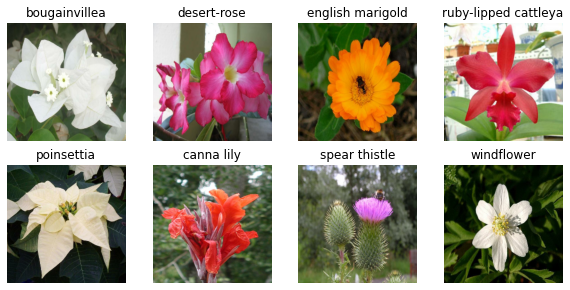

In [40]:
# Show the first 5 images in the training set
plt.figure(figsize=(10, 10))
for i, example in enumerate(train_ds.take(8)):
		image = example['image']
		label = example['label']

		plt.subplot(4, 4, i + 1)
		plt.imshow(image[0] / 255.0)
		plt.title(datasetInfo.features['label'].int2str(label[0]))
		plt.axis('off')

In [42]:
# get 1 image and classify it with MobileNetV3Small
model = keras.applications.MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Get the image
image = next(iter(train_ds))['image']

# Get the output of the model
prediction = model.predict(image)

# Print the prediction that MobileNetV3Small made

print(prediction)

1/1 [==============================] - 1s 728ms/step
[[[[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ...  3.49953985e+00
    -0.00000000e+00 -0.00000000e+00]
   [-0.00000000e+00 -3.71183336e-01 -0.00000000e+00 ...  2.84353328e+00
    -2.07900092e-01 -0.00000000e+00]
   [-0.00000000e+00  5.23445225e+00 -0.00000000e+00 ... -0.00000000e+00
    -0.00000000e+00 -0.00000000e+00]
   ...
   [-0.00000000e+00  1.89700603e+00 -0.00000000e+00 ...  3.05259049e-01
    -0.00000000e+00 -0.00000000e+00]
   [-0.00000000e+00  2.73697317e-01 -0.00000000e+00 ...  1.93806958e+00
    -0.00000000e+00 -0.00000000e+00]
   [-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 ...  6.60872078e+00
     2.80869991e-01 -0.00000000e+00]]

  [[-0.00000000e+00  1.33506072e+00 -0.00000000e+00 ...  5.65364885e+00
    -7.91866519e-03 -0.00000000e+00]
   [-0.00000000e+00  8.29382801e+00 -0.00000000e+00 ... -0.00000000e+00
    -0.00000000e+00 -0.00000000e+00]
   [-0.00000000e+00  1.58755150e+01 -0.00000000e+00 ... -0.0000000

In [43]:
MobileNetV3Small = keras.applications.MobileNetV3Small(
	input_shape=(224, 224, 3),
	include_top=False, 
	weights='imagenet')

# Create the model

model = keras.Sequential()

model.add(MobileNetV3Small)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(102, activation='softmax'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 28224)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               14451200  
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                      

In [44]:
# Compile the model

model.compile(
	optimizer=keras.optimizers.Adam(learning_rate=0.001),
	metrics=['accuracy'],
	loss='binary_crossentropy',
)

# Train the model
history = model.fit(
	train_ds,
	validation_data=test_ds,
	epochs=20,
)


Epoch 1/20


ValueError: in user code:

    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "MobilenetV3small_input". You passed a data dictionary with keys ['file_name', 'image', 'label']. Expected the following keys: ['MobilenetV3small_input']


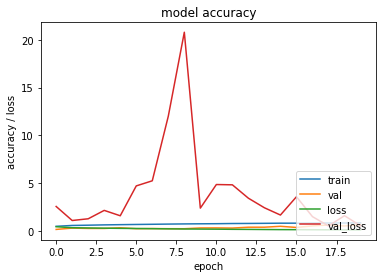

In [ ]:
# Show the model history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy / loss')
plt.xlabel('epoch')
plt.legend(['train', 'val', 'loss', 'val_loss'], loc='lower right')
plt.show()

In [ ]:
# Make all of the model layers trainable
for layer in model.layers:
	layer.trainable = True

model.compile(optimizer=keras.optimizers.Adam(0.000001),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(
  train_ds,
  epochs=20,
  steps_per_epoch=len(train_ds),
  validation_data=test_ds,
)

Epoch 1/20


ValueError: in user code:

    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\mlg\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\input_spec.py", line 197, in assert_input_compatibility
        raise ValueError(

    ValueError: Missing data for input "input_6". You passed a data dictionary with keys ['file_name', 'image', 'label']. Expected the following keys: ['input_6']
